# Notebook illustration of the S2Mix algorithm

Author : Nicolas Jouvin, in collaboration with Yohann De Castro & Rémi Gribonval.

Contact : [nicolas.jouvin@inrae.fr](nicolas.jouvin@inrae.fr)

This notebook shows toy examples of mixture model estimation via Sketched-Supermix optimization problem, *i.e.* a Monte-Carlo version of the problem introduced in [De Castro, Gadat, Marteau and Maugis](https://hal.science/hal-02190117). The optimization problem is solved using conic particle gradient descent [(Chizat, 2020)](https://hal.science/hal-02190822/document).


All the classes and methods are available in the `pblasso_nd.py` module. 

# Introduction

### Mixture estimation problem

Our goal is to recover the true parameters $\{(a_k^\star, m_k^\star)\}_{k=1, \ldots, K^\star}$ of the translation invariant mixture density
$$
f^0 = \sum_{k=1}^{K^\star} a_k^\star \varphi(\cdot - m_k^\star)
$$
from a sample $X = (x_1, \ldots, x_n) \subset \mathbb{R}^d$. In this notebook, $\varphi$ will be the centered Gaussian density with known covariance matrix $\Sigma$ : $\mathcal{N}_d(0, \Sigma)$. However, it can be any symmetric translation invariant density with know Fourier transform $\mathcal{F}[\varphi] = \sigma$.

### S2Mix : Sketched Beurling-Lasso for mixture estimation

> This section is a very crude introduction to BLASSO, Supermix and its sketching version S2Mix in a very concise fashion. For more a more detailed introduction please refer to the preprint.

Introducing the convolution operator $\Phi : \mu \mapsto \varphi \star \mu$, one can write $f^0 = \Phi \mu^\star$ and the parameter estimation problem above may be cast as recovering the true **sparse** measure on the parameter space. 
$$\mu^\star = \sum_{k=1}^{K^\star} a_k^\star \delta_{m_k^\star}$$
Differing from standard approaches such as *e.g.* maximum-likelihood estimation, a classical estimator of $\mu^\star$ is obtained as the solution of an infinite-dimensional analog to the Lasso regression over the space of finite Radon measures $\mathcal{M}(\mathbb{R}^d)$. The latter is known as the Beurling-LASSO [(BLASSO, De Castro et. al. 2012)](https://ydecastro.github.io/research/paper4.pdf) and is defined as
$$ \hat{\mu} \in \underset{\mu}{\arg\min}\frac{1}{2} \Vert y - F \mu \Vert_{\mathbb{F}}^2 + \kappa \Vert \mu \Vert_{TV}.$$
Here, $y$ represents a sample embedding , while $F$ is a linear operator from the Radon measures to some Hilbert space $\mathbb{F}$ to be chosen. The BLASSO enjoys several properties as an optimization problem, in particular convexity allowing to leverage duality for theoretical analysis.

Recently, [De Castro, Gadat, Marteau and Maugis](https://hal.science/hal-02190117) proposed *Supermix* which compares the fourier transform of the sample empirical distribution $\hat{\delta}_n$ to the one of a candidate $\Phi \mu$ in a weighted $L^2(\Lambda)$ space, where $\Lambda$ is some positive measure with density w.r.t to the lebesgues measure.
$$
\begin{equation}
 \hat{\mu} \in \underset{\mu}{\arg\min} \frac{1}{2} \frac{1}{(2\pi)^d} \int_{\mathbb{R}^d} \vert \mathcal{F}[\hat{\delta}_n] - \sigma \mathcal{F}[\mu] \vert^2(\omega) \Lambda(\omega) d \omega  + \kappa \Vert \mu \Vert_{TV} \tag{Supermix}
\end{equation}
$$
They propose to take $\Lambda \propto Unif([-\eta, \eta])$ where $\eta$ is some bandwidth parameter such that $[-\eta, \eta] \subset \textrm{Supp}(\sigma)$. Denoting $\lambda = \mathcal{F}[\Lambda]$, we have that $\tilde{\Lambda} = \frac{\Lambda}{\lambda(0)(2\pi)^d}$ is a normalized probability measure (see e.g. [F. Bach's lecture note p.13](https://www.di.ens.fr/~fbach/learning_theory_class/lecture6.pdf) ).

However, computing the data fitting term (and hence the loss or its gradient) for any candidate $\mu$ requires solving $d$-dimensional integrals w.r.t to $\Lambda$, which is impractical. Hence, we proposose to resort to Monte-Carlo approximation of these integrals with $m$ samples $(\omega_1, \ldots, \omega_m)$ drawn *i.i.d.* from $\tilde{\Lambda}$. This leads to another Beurling-Lasso problem, called sketched-Supermix (S2Mix) with
 * Hilbert space : $\mathbb{F} = (\mathbb{C}^m, \sqrt{\frac{\gamma}{m}} \Vert \cdot \Vert_{\mathbb{C}^m})$ 
 * Sample embedding : $y = \left(\frac{1}{n} \sum_{i=1}^n e^{-i \omega_j^\top x_i} \right)_{j=1}^m$
 * Linear operator : $F(\mu) = \left( \sigma(\omega_j) \mathcal{F}[\mu](\omega_j) \right)_{j=1}^m$, where we recall that $\sigma = \mathcal{F}[\varphi]$.

The *sketching* terminology comes from the fact that the $n \times d$ dataset $X$ is reduced to an $m$ dimensional random vector $y$ (the *sketch*) which can be precomputed once and for all, which is relevant for saving both computations and memory [(Gribonval et. al. 2021)](https://inria.hal.science/hal-02909766v2/document). Here, the so-called sketching operator is $\mathcal{A}_m : \nu \mapsto (\mathcal{F}[\nu](\omega_j))_{j=1}^m$, also known as Random Fourier Feature (RFFs) since the fourier transform is only measured at randomly sampled frequencies. Moreover, we can rewrite $F = \mathcal{A}_m \circ \Phi$ and the S2Mix program
$$
\begin{equation}
\hat{\mu} \in \underset{\mu}{\arg\min} \left\{ J(\mu) := \frac{\gamma}{m} \frac{1}{2} \Vert \mathcal{A}_m \hat{\delta}_n - \mathcal{A}_m \circ \Phi \mu \Vert_{\mathcal{C}^m}^2 + \kappa \Vert \mu \Vert_{TV} =  \frac{1}{2} \frac{\gamma}{m} \sum_{j=1}^m \vert  y_j - \sigma(\omega_j) \mathcal{F}[\mu](\omega_j) \vert^2 + \kappa \Vert \mu \Vert_{TV} \right\}. \tag{S2Mix}
\end{equation}
$$


Here $\gamma = \mathcal{F}[\Lambda](0)$ is some constant, independent from any model parameters (but may depend on the dimension $d$ and bandwidth $\eta$), ensuring $\mathbb{E}_\omega[\frac{\gamma}{m} \Vert \mathcal{A}_m \nu \Vert^2_{\mathbb{C}^m}] = \Vert \mathcal{F}[\nu] \Vert_{L^2(\Lambda)}^2 $ and hence the asymptotic convergence of the S2Mix objective to the one of Supermix as $m \to + \infty$ (law of large numbers). 



### Conic particle gradient descent
[Chizat, 2020](https://hal.science/hal-02190822/document) proposed a very general framework for solving sparse optimization problem on the space of measures, such as the BLASSO. The idea is to use a discretisation of the candidate measure $\mu_K = \sum_{k=1}^K r_k^2 \delta_{m_k}$ and to minimize the corresponding objective
$$ 
H_K((r_1, m_1), \ldots, (r_K, m_K)) = J(\mu_K)
$$
by gradient descent on the particles $(r,m) = ((r_k, m_k))_{k=1, \ldots, K}$. However, Chizat propose to use a specific Riemannian metric on the space of particles $(r, m)$, and hence specific Riemannian gradients, allowing to leverage theoretical convergence guarantees to global optima for this non-convex discrete problem. More details may be found in the original article, we only detail the Riemannian gradient of $H_K$ w.r.t. $r_k$ and $m_k$ which are given for the general case in Section 2.
$$
\begin{cases}
\nabla_{r_k} H_K(r,m) = 2 \alpha r_k J'_{\mu_K}(m_k)   \\
\nabla_{m_k} H_K(r, m)  = \beta \nabla_{m_k} J'_{\mu_K}(m_k)
\end{cases} \qquad \textrm{with: } \mu_K = \frac{1}{K} \sum_{k=1}^K r_k^2 \delta_{m_k}
$$
with 
$$
\begin{cases}
J'_{\mu_K}(m_k) = \frac{\gamma}{m} \left\{\sum_{j=1}^m  \sigma^2(\omega_j)\sum_{l=1}^K \frac{r_l^2}{K} \cos\left( \omega_j^\top (m_l - m_k)\right) - \sum_{j=1}^m \sigma(\omega_j)\left( Re(y_j) \cos(\omega_j^\top m_k) - Im(y_j) \sin(\omega_j^\top m_k) \right) \right\} + \kappa \\
\nabla_{m_k} J'_{\mu_K}(m_k) = \frac{\gamma}{m} \left\{\sum_{j=1}^m \omega_j \sigma^2(\omega_j)\sum_{l=1}^K \frac{r_l^2}{K} \sin\left( \omega_j^\top (m_l - m_k)\right) - \sum_{j=1}^m \omega_j \sigma(\omega_j)\left( - Re(y_j) \sin(\omega_j^\top m_k) - Im(y_j) \cos(\omega_j^\top m_k) \right)  \right\}
\end{cases} \qquad \textrm{with: } \mu_K = \frac{1}{K} \sum_{k=1}^K r_k^2 \delta_{m_k}
$$

The hyper-parameters $\alpha$ and $\beta$ can be interpreted as step sizes in the gradient descent


# Implementation

The S2Mix optimization problem can be declared via the `SketchedSupermix` class. One needs to specify

* the sketching operator, *i.e.* $\mathcal{A}_m$ which draws $(\omega_j)_j$ and computes $y$ through the `SketchingOperator` class.
* The mixture model, *i.e.* the template distribution $\varphi$. For now only GMMs are implemented
* The regularization $\kappa$
* A random seed
* A covariance matrix, since it is assumed to be known.

All class are implemented in the `pblasso.py` file, along with a `Gmm` class to sample from a Gaussian mixture with given parameters.

In [1]:
from particle_blasso.mixture import SketchingOperator, SketchedSupermix
from particle_blasso.data import Gmm

In [2]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# seed for numpy default_rng instanciation
seed = int(np.random.default_rng().random()* 1e8) 
seed = 42
print('Seed = {}'.format(seed))

Seed = 42


## A first example with 1-dimensional GMM estimation


### Set simulation parameters

In the next cell, we set the true parameters of the Gaussian mixture

In [3]:
# Parameters
n_spikes = 3
d = 1
min_separation = 10
n = int(400)

amplitudes = np.repeat(1, n_spikes) / n_spikes
means = np.zeros((n_spikes, d))
means[:, 0] = min_separation * np.arange(n_spikes)
sigmas = np.array([np.eye(d) for _ in range(n_spikes)])
gmm = Gmm(n_spikes=n_spikes, d=d, min_separation=min_separation, seed=seed)
gmm.mixing_law(means=means, sigmas=sigmas, amplitudes=amplitudes)
gmm.sampling(n=n)

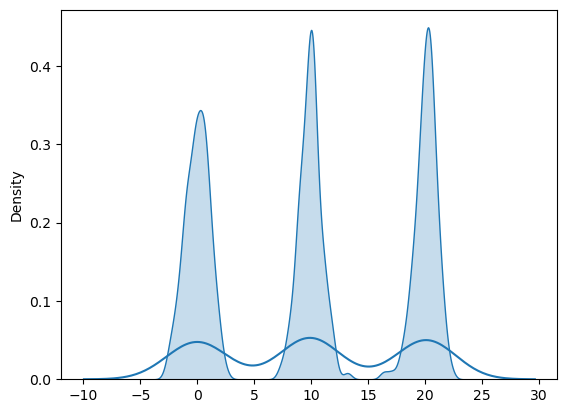

In [4]:
gmm.plot_distribution(show_component=True)

### Sketching operator

One must choose the number of sketches $m$ and the sketching distribution $\Lambda$. The latter has a bandwidth hyper-parameter controlling it support. For example, when the distribution is uniform $\Lambda = \mathcal{U}_{[-bandwith, bandwith]}$. The bandwith parameter is theoretically linked to the inverse of the minimal separation $\Delta=\min_{k\neq l} \Vert m_k^\star - m_l^\star \Vert_2$, thus it is of crucial importance to select a large enough frequency bandwith to be able to recover $\mu^\star$ from S2Mix. However, the larger the bandwidth, the larger the number of sketches $m$ needs to be. 

In [5]:
# --- Create Sketching Operator
n_sketches = int(100) # m
sketch_dist = "uniform" 
bandwidth = 10 
uniform_sketcher = SketchingOperator(
    n_sketches=n_sketches,
    bandwidth=bandwidth,
    seed=seed,
    sketching_distribution=sketch_dist,
)
uniform_sketcher.fit_transform(X=gmm.sample)

In [6]:
uniform_sketcher.data_sketch[:10] # the sketch (y_j)_j

array([ 0.0116319 +0.06317711j,  0.45711304-0.16668655j,
       -0.02015857+0.01982018j, -0.03661806-0.0326865j ,
       -0.01452472+0.00491166j, -0.05740414+0.01325667j,
       -0.01708557-0.02486873j,  0.02834968-0.02162321j,
        0.03714882-0.00714068j,  0.0682422 +0.11829069j])

In [7]:
uniform_sketcher.frequencies_.shape # the \omega_j's

(100, 1)

### Creating the S2Mix problem

The S2Mix problem is created via the `SketchedSupermix` class. In addition to the sketching operator above, one needs to specify the regularization $\kappa$ and the model. 


In [8]:
# --- Create the S2Mix problem
kappa_reg = 1e-6 # * (2 * np.pi) ** d *  (2 ** d) * (1 / ((2 * uniform_sketcher.bandwidth) ** d))
model = "gmm"
blasso = SketchedSupermix(
    sketcher=uniform_sketcher,
    model=model,
    kappa_reg=kappa_reg,
    seed=seed,
    variance=None, # np.eye(d) by default
)
# For now, we don't have an estimate of the measure \mu^\star
blasso.fitted_

False

### Solving S2mix with CPGD
In the next cell, we set the hyper-parameters for the CPGD algorithm. Namely:

* $\alpha$ and $\beta$ the gradient steps in the particle's space
* The number of particles
* The number of iterations

Optionally, one can give the initialization for the particles $(r_k, m_k)$, by default the initialization is random for $m_k$ while $r_k=1, \forall k$.

In [9]:
# --- Fit with CPGD
eta = 10
step_r = 0.01 * eta
step_m = 0.01 * eta
step_sizes = {"rs": step_r, "means": step_m}

n_particles = 10
n_iter = int(1e4)
mirror_retraction = False

t0 = time.time()
blasso.fit(
    algorithm="cpgd",
    n_particles=n_particles,
    n_iter=n_iter,
    init={"rs": None, "params":{"means": None}}, # random initialization
    mirror_retraction=mirror_retraction,
    step_sizes=step_sizes,
)
t1 = time.time()
print(f"Ran {n_iter} interations of CPGD in {t1- t0} seconds.")
blasso.fitted_

/home/nicolas/Recherche/Packages/particle_blasso/particle_blasso/_solvers/_ConicPGD.py:71: RuntimeWarning: invalid value encountered in multiply
  self.losses_ = np.nan * np.empty(n_iter)


Ran 10000 interations of CPGD in 4.974285364151001 seconds.


True

### Visualizing the algorithm

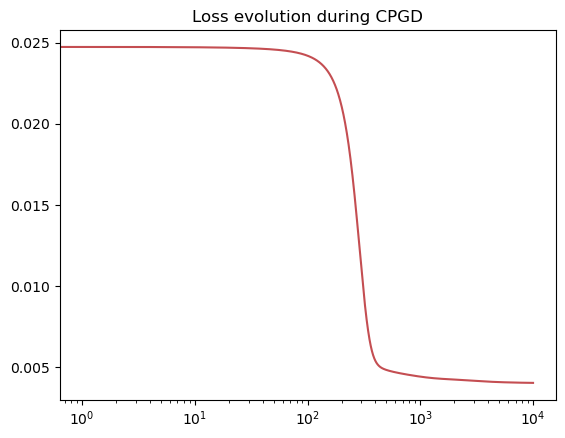

In [10]:
blasso.plot(type="loss")

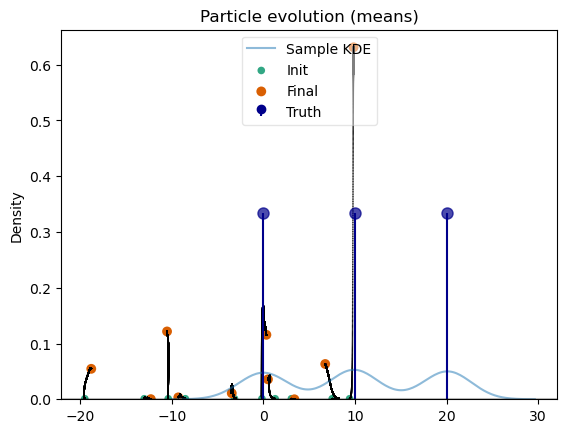

In [11]:
# particle evolution in (r, m) space (1-D case)
blasso.plot(type="param", param_name="means", true_params = (gmm.amplitudes, gmm.means), sample=gmm.sample) 

We see that some particle tends to be drawn to the true parameters while others vanish with very few displacements.

The un-normalized mixture weights $r_k^2/K$ are stored in the `amplitudes` attribute. Note that they are not constrained to respect the simplex constraint.

In [12]:
print(blasso.amplitudes_)
# formula
np.alltrue(blasso.amplitudes_ == (blasso.rs_ ** 2 / blasso.cpgd_.n_particles))

[6.03974766e-06 1.21645695e-01 6.32975099e-02 6.31225760e-01
 5.46199934e-02 2.73370796e-04 3.57597912e-02 1.09173447e-02
 1.15604009e-01 3.47618205e-03]


True

In [13]:
blasso.amplitudes_.sum() # un-normalized mixture weights estimated via CPGD

1.0368256949834467

In [14]:
# particle (r_k, m_k) at the end of CPGD
print(blasso.rs_)
print(blasso.means_)

[0.00777158 1.10293107 0.79559732 2.51242066 0.7390534  0.05228487
 0.59799491 0.33041405 1.07519305 0.18644522]
[[  3.37975075]
 [-10.52824891]
 [  6.7433309 ]
 [  9.84031407]
 [-18.80321081]
 [-12.29885764]
 [  0.49054782]
 [ -3.46258198]
 [  0.32053039]
 [ -9.29757456]]


### Custom initialisation of CPGD

It is possible to use your own initialization for the particle $(r,m)$. The example below use the class proportions and barycenter of a Kmeans clustering. We only have to make a new call to the `.fit` method.

In [15]:
# --- Kmeans init
n_particles=7
km = KMeans(n_clusters=n_particles, random_state=seed, n_init=10)
km.fit(gmm.sample)
mean_init = km.cluster_centers_

_, r_init = np.unique(km.labels_, return_counts=True)
r_init = np.sqrt(
    (r_init / gmm.n_sample) * n_particles
)  # re-scale the particle weights

# - Fit CPGD with custom init
blasso.fit(
    algorithm="cpgd",
    n_particles=n_particles,
    n_iter=int(1e4),
    init={"rs": r_init, "params": {"means": mean_init}}, # custom initialization
    mirror_retraction=mirror_retraction,
    step_sizes=step_sizes,
)


The object has already been fitted. The particles are forgotten, re-fitting using a new initialisation.


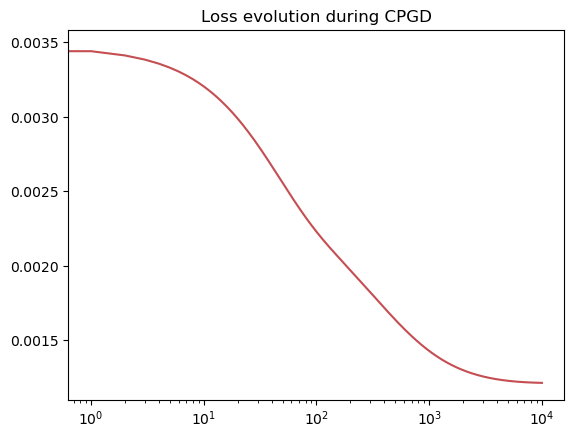

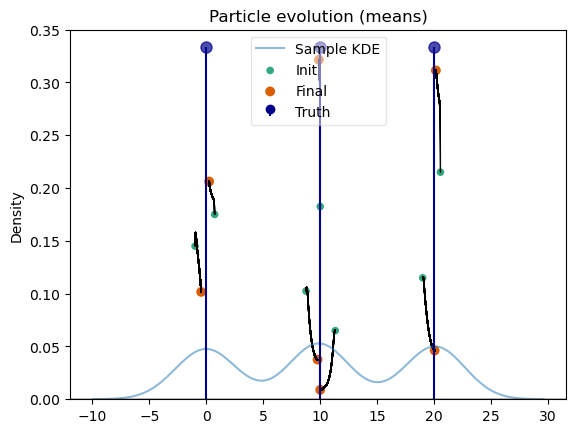

In [16]:
blasso.plot("loss")
blasso.plot(type="param", param_name="means", true_params = (gmm.amplitudes, gmm.means), sample=gmm.sample) 

In [17]:
sum(blasso.amplitudes_)

1.0336047498836192

## A 2-dimensional GMM estimation (Encore en chantier, ne fonctionne pas très bien)

On reste coincé dans des minima locaux.


In [18]:
# Parameters
n_spikes = 3
d = 2
min_separation = 10
n = int(800)
amplitudes_2d = np.repeat(1, n_spikes) / n_spikes
means_2d = np.zeros((n_spikes, d))
means_2d[:, 0] = min_separation * np.arange(n_spikes)
means_2d[:, 1:] = np.random.normal(loc=0, scale=1, size=(n_spikes, d - 1))
sigmas_2d = np.array([np.eye(d) for _ in range(n_spikes)])
gmm_2d = Gmm(n_spikes=n_spikes, d=d, min_separation=min_separation, seed=seed)
gmm_2d.mixing_law(means=means_2d, sigmas=sigmas_2d, amplitudes=amplitudes_2d)
gmm_2d.sampling(n=n)

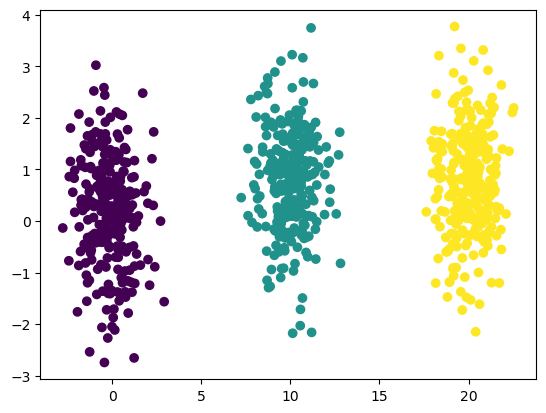

In [19]:
plt.scatter(gmm_2d.sample[:, 0], gmm_2d.sample[:, 1], c=gmm_2d.clust)

In [20]:
# --- Create Sketching Operator
n_sketches = int(100) 
sketch_dist = "uniform" 
bandwidth = 10 
uniform_sketcher = SketchingOperator(
    n_sketches=n_sketches,
    bandwidth=bandwidth,
    seed=seed,
    sketching_distribution=sketch_dist,
)
uniform_sketcher.fit_transform(X=gmm_2d.sample)

# --- Create the S2Mix problem
kappa_reg = 1e-5
model = "gmm"
blasso = SketchedSupermix(
    sketcher=uniform_sketcher,
    model=model,
    kappa_reg=kappa_reg,
    seed=seed,
    variance=None, # np.eye(d) by default
)

# --- Kmeans init
n_particles=10
km = KMeans(n_clusters=n_particles, random_state=seed, n_init=10)
km.fit(gmm_2d.sample)
mean_init = km.cluster_centers_

_, r_init = np.unique(km.labels_, return_counts=True)
r_init = np.sqrt(
    (r_init / gmm_2d.n_sample) * n_particles
)  # re-scale the particle weights


# - Fit CPGD with custom init
r_init = (1 / n_particles) * np.ones(n_particles)
mean_init = gmm_2d.sample[np.random.default_rng(seed).choice(np.arange(1, n), size = n_particles, replace=False), :]
eta = 10
step_sizes = {"rs": 0.1 * eta, "means": 0.1 * eta}
blasso.fit(
    algorithm="cpgd",
    n_particles=n_particles,
    n_iter=int(1e4),
    init={"rs": r_init, "params": {"means": mean_init}}, 
    mirror_retraction=mirror_retraction,
    step_sizes=step_sizes,
)

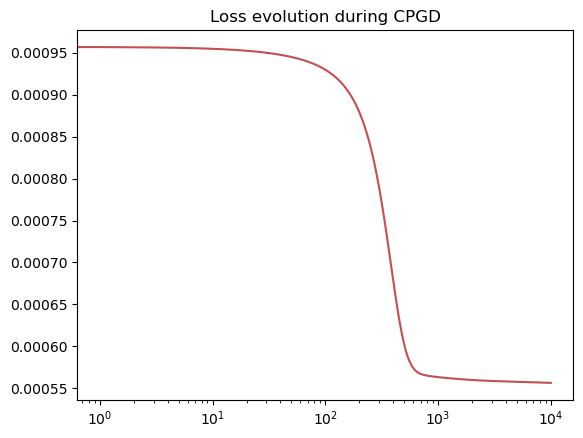

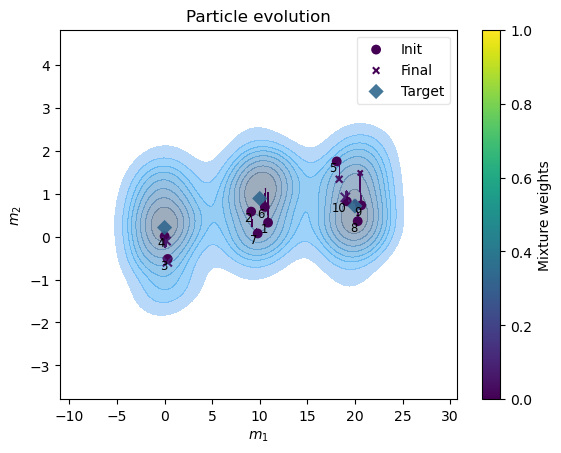

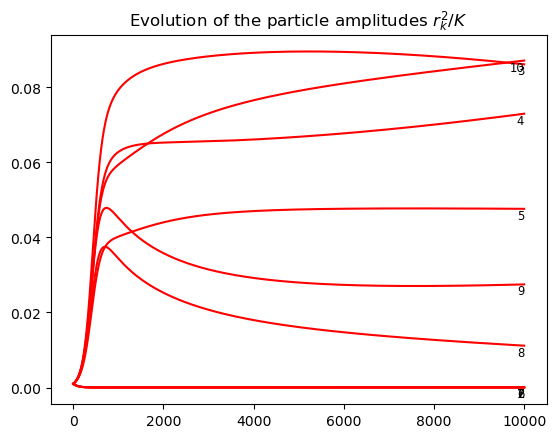

In [21]:
blasso.plot('loss')
blasso.plot('param', param_name="means", sample=gmm_2d.sample, true_params=(amplitudes_2d, means_2d))
blasso.plot('amplitudes')

In [22]:
print(blasso.amplitudes_.sum())
blasso.amplitudes_

0.33262802483481513


array([3.50907823e-05, 3.52189247e-05, 8.61158591e-02, 7.29586831e-02,
       4.76184415e-02, 5.57661030e-05, 3.76070530e-05, 1.11614597e-02,
       2.74849746e-02, 8.71249240e-02])

# Soft-thresholding effect 

The minimum amplitude that can be recovered by the method depends on the regularization $\kappa_n$ that will "kill" small spikes in a so-called soft-thresholding effect (the higher $\kappa_n$, the bigger the effect). 

<StemContainer object of 3 artists>

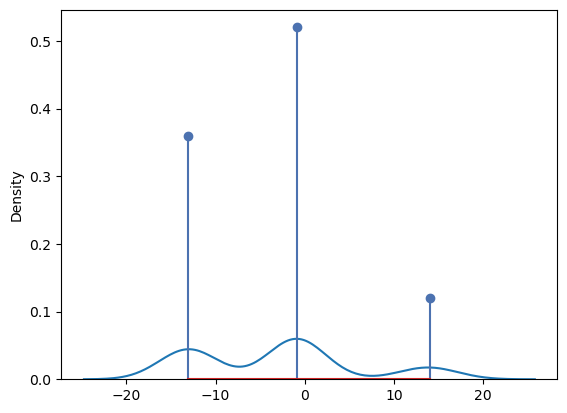

In [23]:
# Parameters (replication of Supermix expe, see legend of Fig. 1 in Supermix)
n_spikes = 3
n = 200
d=1
amplitudes = np.array([0.36, 0.52, 0.12])
means = np.array([[-13.1, -0.9, 14.0]]).T
sigmas = np.array([np.eye(d) for _ in range(n_spikes)])

gmm = Gmm(n_spikes=n_spikes, d=d, min_separation=min_separation, seed=seed)
gmm.mixing_law(means=means, sigmas=sigmas, amplitudes=amplitudes)
gmm.sampling(n=n, display=True)
plt.stem(gmm.means, gmm.amplitudes, 'b')

In [24]:
# Create the S2Mix problem with Supermix hyper-params (see legend of Fig. 1 in Supermix)


# --- Create Sketching Operator
n_sketches = int(100) 
sketch_dist = "uniform" 
bandwidth = 1/ 0.1
uniform_sketcher = SketchingOperator(
    n_sketches=n_sketches,
    bandwidth=bandwidth,
    seed=seed,
    sketching_distribution=sketch_dist,
)
uniform_sketcher.fit_transform(X=gmm.sample)


# --- S2Mix problem with Supermix hyperparameters
kappa_reg = 1e-2
model = "gmm"
blasso_soft_thresholding = SketchedSupermix(
    sketcher=uniform_sketcher,
    model=model,
    kappa_reg=kappa_reg,
    seed=seed,
    variance=None, # np.eye(d) by default
)

# --- CPGD
n_particles=20
mean_init = np.linspace(start=-20, stop=20, num=n_particles)[:, np.newaxis] # linearly space particles init
mean_init = mean_init - np.mean(mean_init)
r_init = np.repeat(np.sqrt(0.1 * n_particles), n_particles)

# - Fit CPGD with Supermix experiments' hyperparameter
alpha, beta = 0.05, 1
step_sizes = {"rs": alpha, "means": beta}
blasso_soft_thresholding.fit(
    algorithm="cpgd",
    n_particles=n_particles,
    n_iter=int(5e3),
    init={"rs": r_init, "params": {"means": mean_init}}, 
    #init={"rs": None, "params": {"means": None}}, 
    mirror_retraction=mirror_retraction,
    step_sizes=step_sizes,
)

print(blasso_soft_thresholding.amplitudes_.sum())
blasso_soft_thresholding.amplitudes_

0.655363069394108


array([4.26643689e-06, 4.91271390e-06, 3.60360450e-02, 8.44661882e-02,
       8.54925669e-02, 3.34950233e-02, 9.06610232e-06, 6.86784106e-06,
       1.22074701e-01, 1.61536704e-01, 1.18088148e-01, 7.99282486e-05,
       9.31471202e-05, 2.06945402e-04, 2.80283578e-04, 2.40813752e-03,
       5.72179487e-03, 4.50176096e-03, 8.51911139e-04, 4.67041062e-06])

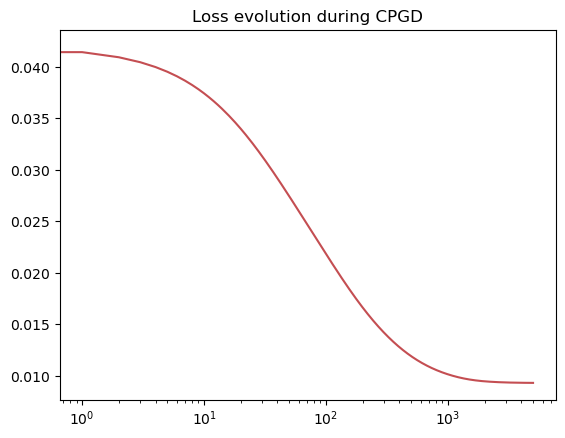

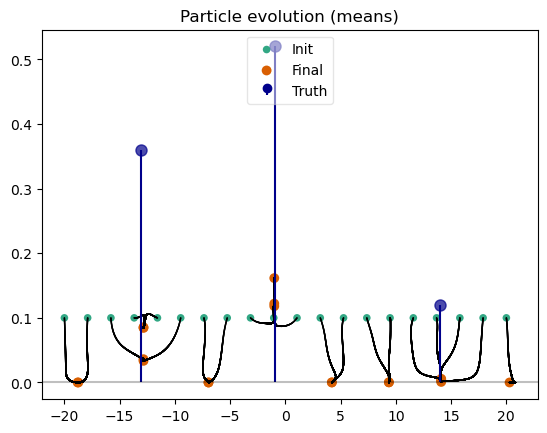

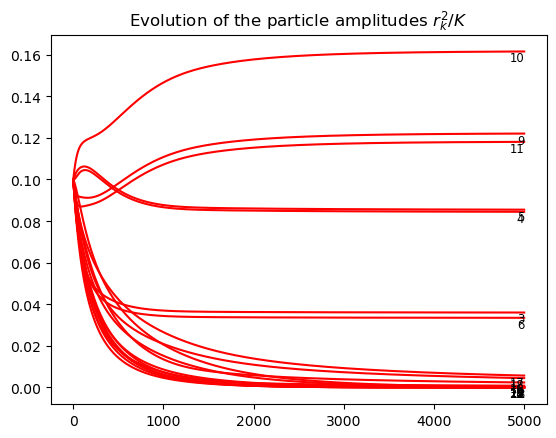

In [25]:
blasso_soft_thresholding.plot("loss")
blasso_soft_thresholding.plot(type="param", param_name="means", true_params = (gmm.amplitudes, gmm.means)) 
blasso_soft_thresholding.plot("amplitudes")